#Cockcroft-Walton Voltage Curves

##Goal
Understand how the high voltage setup behaves under high loads

##Prodecure

1) Connect to the Arduino via the Windows Bluetooth menu, and determine the port used by the Arduino. Using a terminal viewer program, give the "go" command to the Arduino.

2) Turn on variac

3) Increase variac voltage in intervals of 20 up to 140

4) Slowly turn the voltage back down to 0. Send the "stop" command to the Arduino.

5) Upload the output TXT file to Google Drive, and create a new `Experiment` object

##Shared code utilities

In [0]:
!pip install --upgrade --quiet gspread

import csv
import os

from google.colab import auth
from google.colab import drive
import gspread
from oauth2client.client import GoogleCredentials
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

auth.authenticate_user()
GC = gspread.authorize(GoogleCredentials.get_application_default())
drive.mount('/content/gdrive', force_remount=True)

ROOT_DIR = "/content/gdrive/My Drive/"
BASE_DIR = ROOT_DIR + 'fusor-hv/'
LOGS_OUTPUT = "Cockcroft-Walton outputs {:.1f} kV from {:.1f} V at {:.1f} mA (totaling {:.1f} W) with {:.2f} MΩ resistor"

class Experiment:
  def __init__(self, filename, bounds):
    self.filename = filename
    self.start_row = bounds[0]
    self.end_row = bounds[1]

    # Data series
    self.times = []
    self.variac_out = []
    self.nst_out = []
    self.cockcroft_walton_out = []

    rows = list(csv.reader(open(BASE_DIR + self.filename)))[self.start_row:self.end_row]
    for i in range(0, len(rows)):
      r = [k for k in rows[i][0].split(" ") if k]
      self.times.append(int(r[0]))
      self.variac_out.append(float(r[3]))
      self.nst_out.append(float(r[6]))
      self.cockcroft_walton_out.append(float(r[8]))
  
  def show_time_plot(self):
    figure = plt.figure()
    figure.set_size_inches(20, 10)
    axes = figure.add_subplot(111)

    #axes.scatter(self.times, self.variac_out, s=10, c='b', label='Variac')
    axes.scatter(self.times, self.nst_out, s=10, c= 'g', label='NST')
    axes.scatter(self.times, self.cockcroft_walton_out, s=10, c='r', label='CW')
    plt.legend(loc='upper left');
    plt.show()

  def show_voltage_curve(self):
    figure = plt.figure()
    figure.set_size_inches(20, 10)
    axes = figure.add_subplot(111)

    axes.scatter(self.variac_out, self.cockcroft_walton_out, s=10, c='r', label='CW')
    plt.legend(loc='upper left');
    plt.show()

  def print_wattage(self, mohms, input_voltage=140):
    m, b = np.polyfit(self.variac_out, self.cockcroft_walton_out, 1)
    cw_out_kv = (input_voltage * m + b)
    current_ma = cw_out_kv / mohms
    watts = cw_out_kv * current_ma
    print(LOGS_OUTPUT.format(cw_out_kv, input_voltage, current_ma, watts, mohms))

  def add_best_fit_line(self, y=None, **kwargs):
    if y is None:
      y = self.cockcroft_walton_out
    x_axis = np.unique(self.variac_out)
    b, m = np.polyfit(self.variac_out, y, 1)
    plt.plot(x_axis, np.poly1d((b, m))(x_axis), **kwargs)

Mounted at /content/gdrive


##Board A & 400 MΩ Load

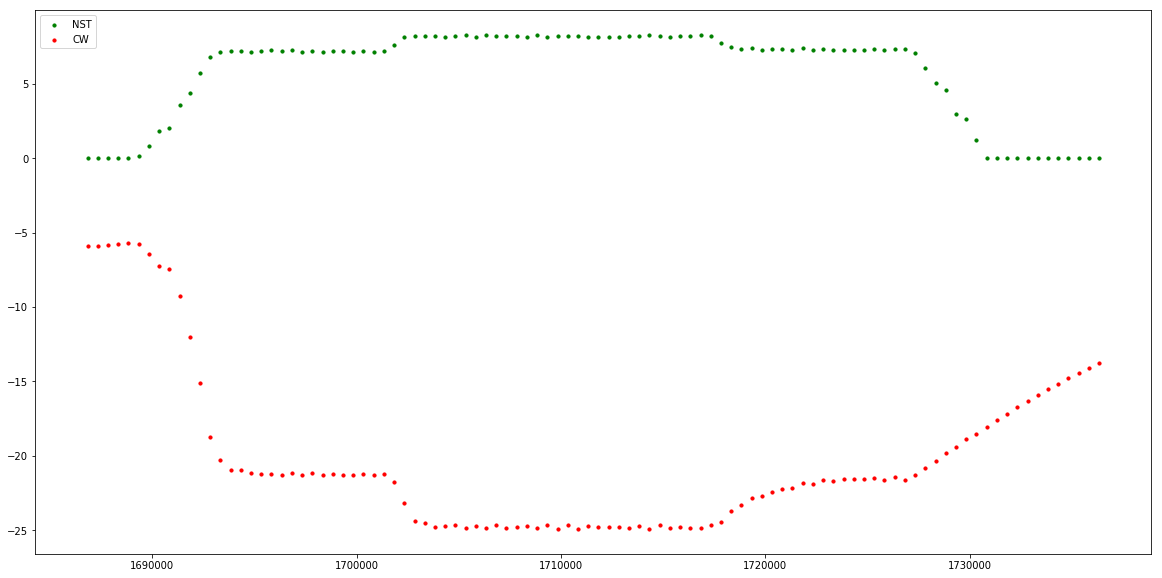

In [0]:
boardA400Mohm = Experiment("CWStageA400Mohm.txt", (0, 100))
boardA400Mohm.show_time_plot()

##Board B & 400 MΩ Load

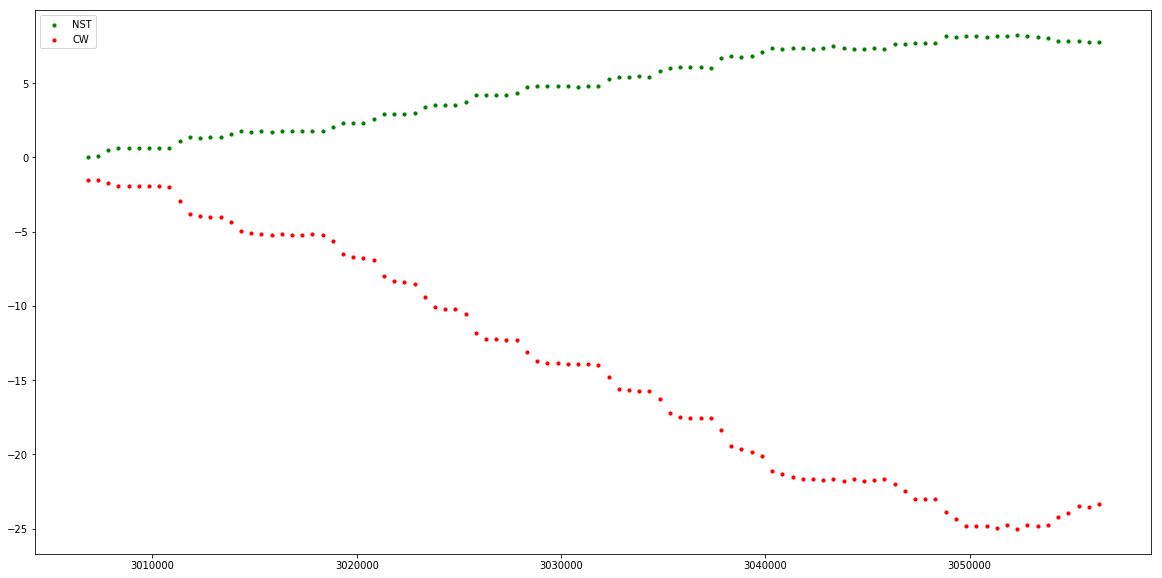

In [0]:
boardB400Mohm = Experiment("CWStageB400Mohm.txt", (0, 100))
boardB400Mohm.show_time_plot()

##Two Boards & 400 MΩ Load

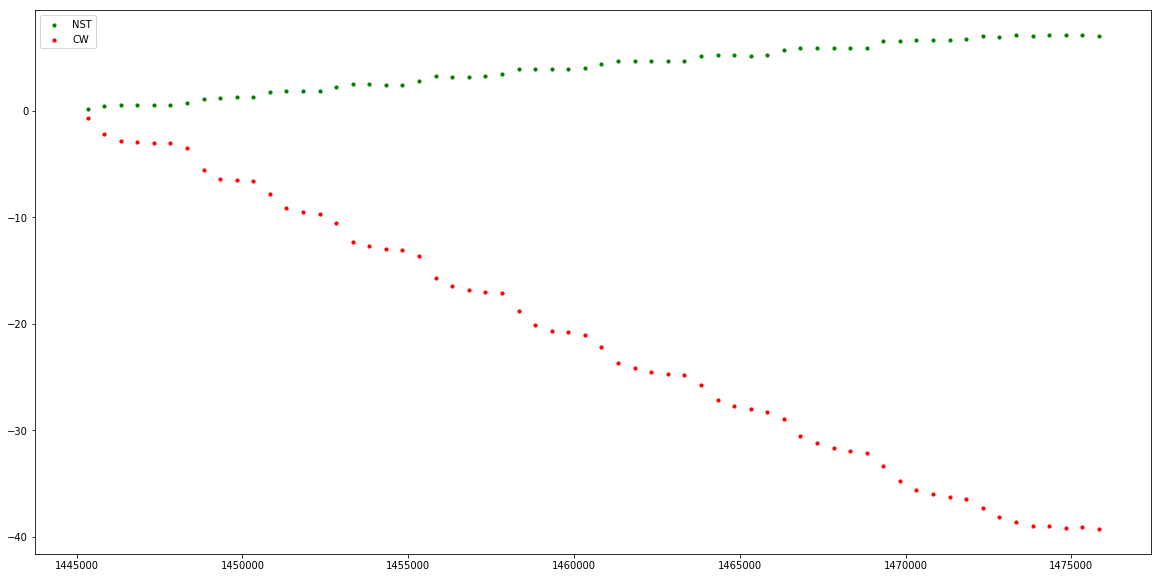

In [0]:
twoStage400Mohm = Experiment("CWTwoStage400Mohm.txt", (188, 250))
twoStage400Mohm.show_time_plot()

##Two Boards & 33 MΩ Load

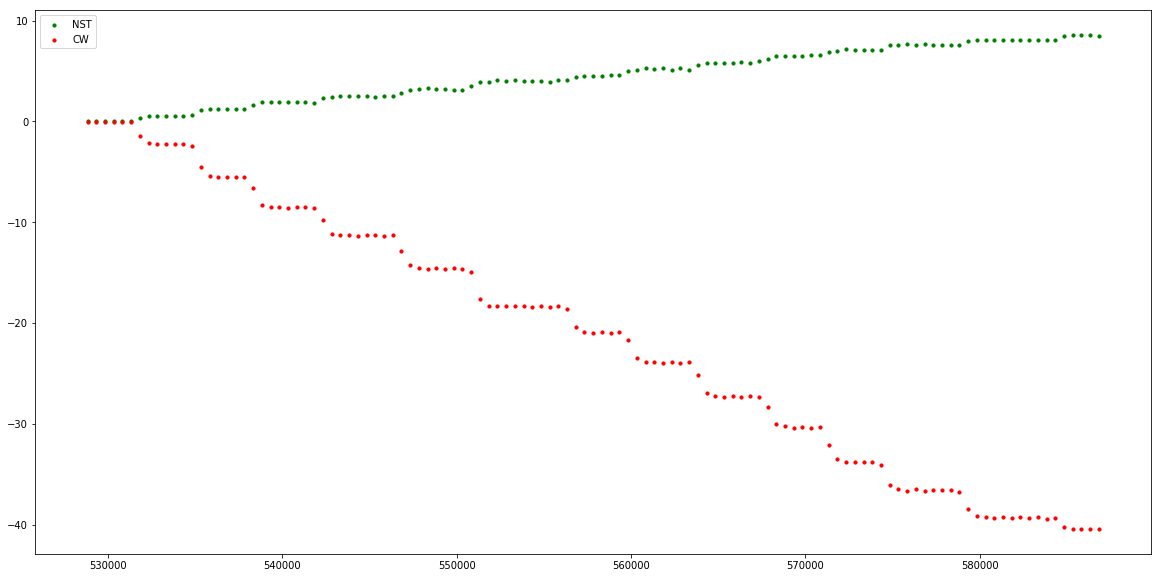

In [0]:
twoStage33Mohm = Experiment("CWTwoStage33Mohm.txt", (50, 167))
twoStage33Mohm.show_time_plot()

##Two Boards & 12 MΩ Load to 120V

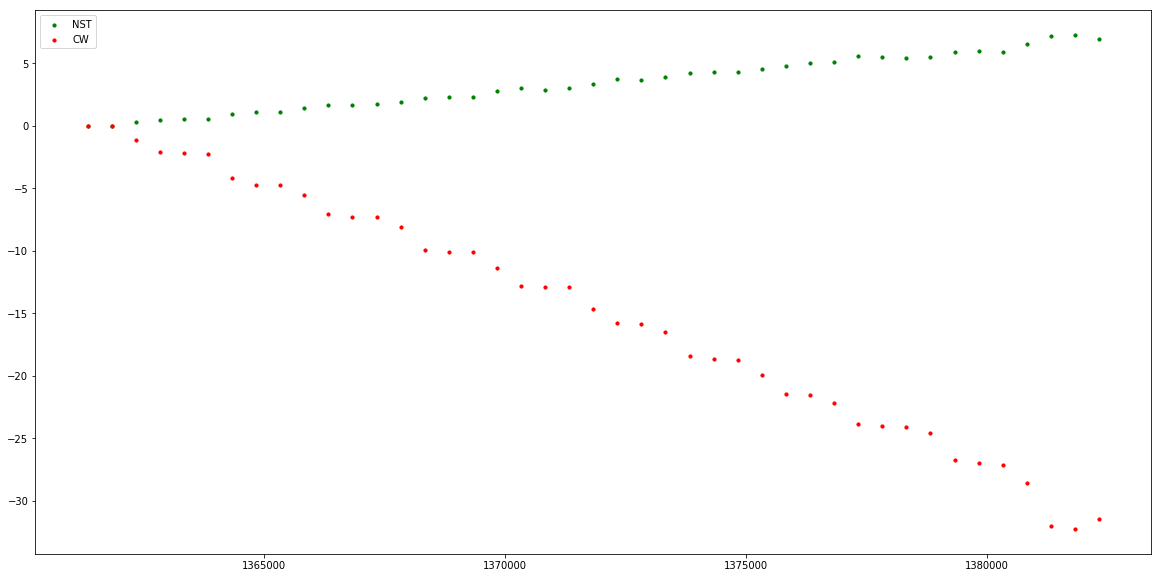

In [0]:
twoStage12Mohm = Experiment("CWTwoStage12Mohm.txt", (24, 67))
twoStage12Mohm.show_time_plot()

##Two Boards & 12 MΩ Load to 140V

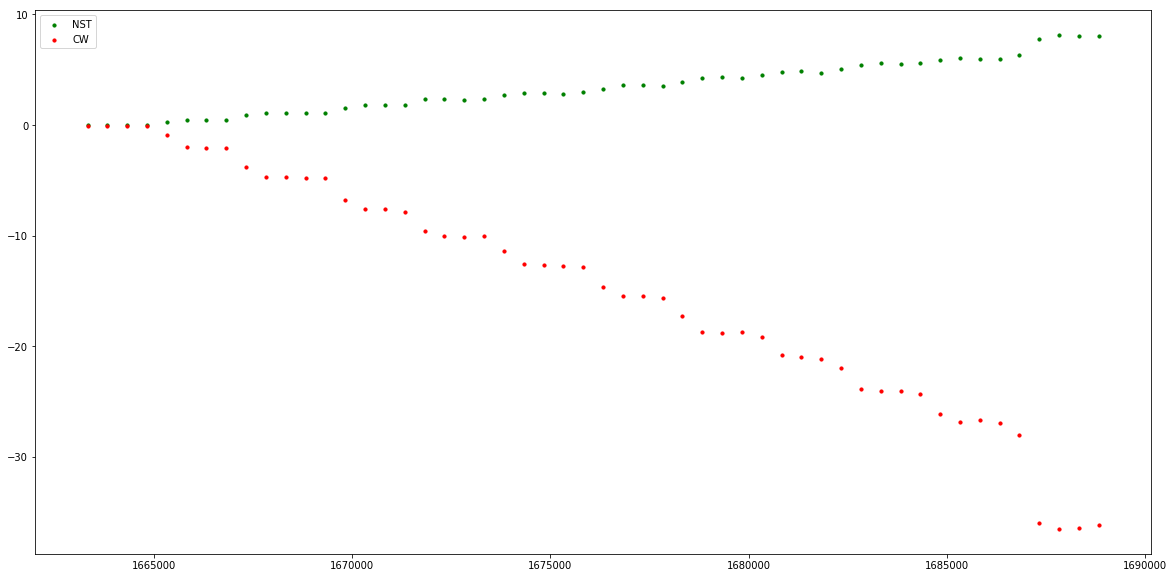

In [0]:
twoStage12Mohm2 = Experiment("CWTwoStage12Mohm140V.txt", (20, 72))
twoStage12Mohm2.show_time_plot()

##Two Boards & 3.3 MΩ Load Spikes

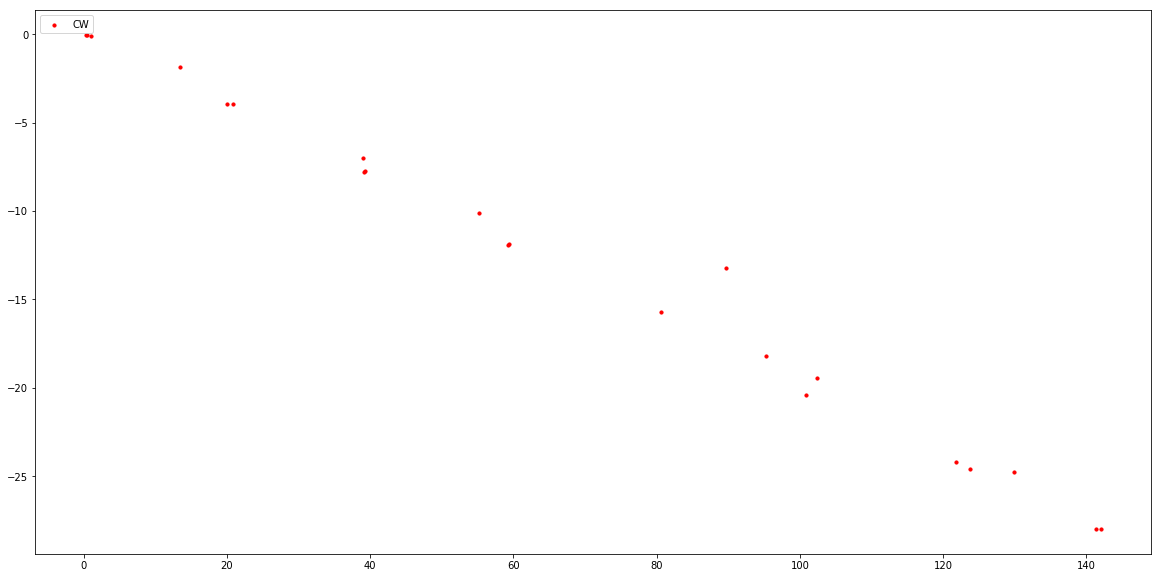

In [0]:
twoStage3Mohm = Experiment("CWTwoStage3MohmSpikedCroppedComplete.txt", (0, 22))
twoStage3Mohm.show_voltage_curve()

##Old voltage curves comparison

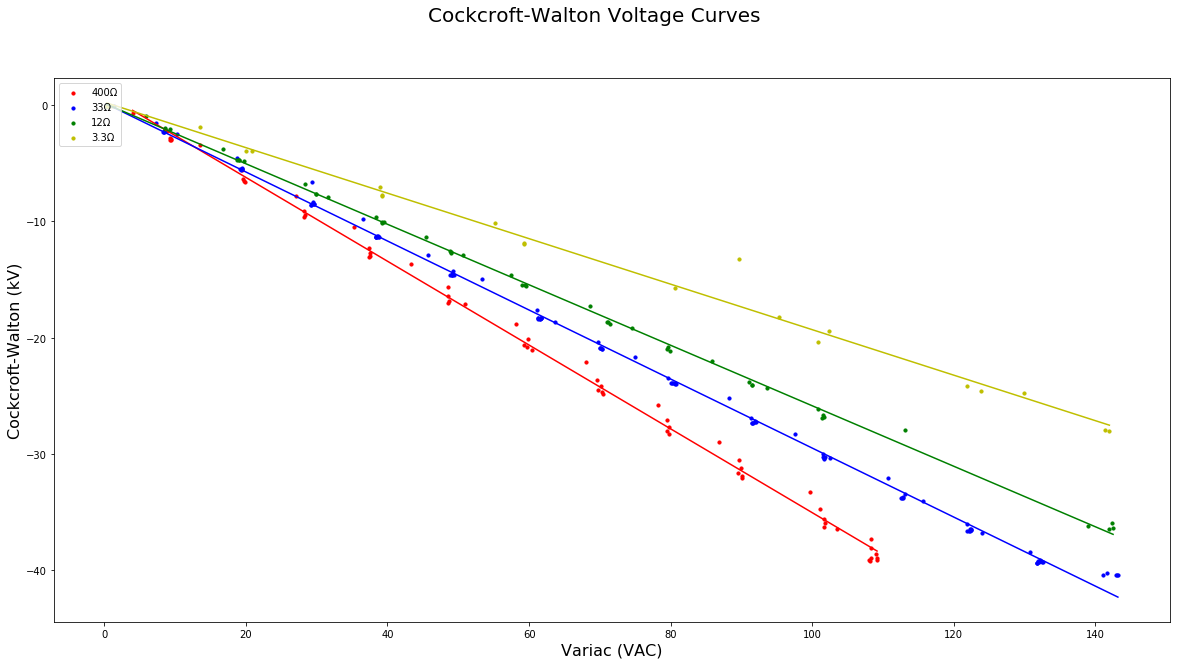

In [0]:
figure = plt.figure()
figure.set_size_inches(20, 10)
axes = figure.add_subplot(111)
figure.suptitle('Cockcroft-Walton Voltage Curves', fontsize=20)
plt.xlabel('Variac (VAC)', fontsize=16)
plt.ylabel('Cockcroft-Walton (kV)', fontsize=16)


twoStage400Mohm.add_best_fit_line(c='r')
twoStage33Mohm.add_best_fit_line(c='b')
twoStage12Mohm2.add_best_fit_line(c='g')
twoStage3Mohm.add_best_fit_line(c='y')

axes.scatter(twoStage400Mohm.variac_out, twoStage400Mohm.cockcroft_walton_out, s=10, c='r', label='400Ω')
axes.scatter(twoStage33Mohm.variac_out, twoStage33Mohm.cockcroft_walton_out, s=10, c='b', label='33Ω')
axes.scatter(twoStage12Mohm2.variac_out, twoStage12Mohm2.cockcroft_walton_out, s=10, c='g', label='12Ω')
axes.scatter(twoStage3Mohm.variac_out, twoStage3Mohm.cockcroft_walton_out, s=10, c='y', label='3.3Ω')
plt.legend(loc='upper left');
plt.show()

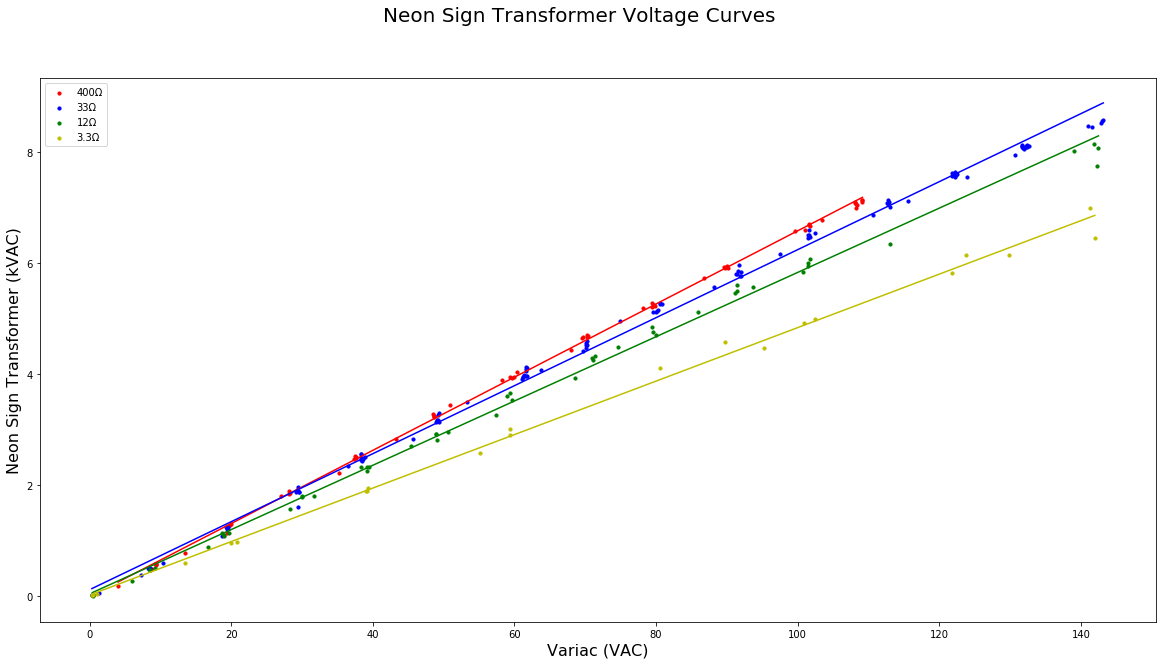

In [0]:
figure = plt.figure()
figure.set_size_inches(20, 10)
axes = figure.add_subplot(111)
figure.suptitle('Neon Sign Transformer Voltage Curves', fontsize=20)
plt.xlabel('Variac (VAC)', fontsize=16)
plt.ylabel('Neon Sign Transformer (kVAC)', fontsize=16)

twoStage400Mohm.add_best_fit_line(y=twoStage400Mohm.nst_out, c='r')
twoStage33Mohm.add_best_fit_line(y=twoStage33Mohm.nst_out, c='b')
twoStage12Mohm2.add_best_fit_line(y=twoStage12Mohm2.nst_out, c='g')
twoStage3Mohm.add_best_fit_line(y=twoStage3Mohm.nst_out, c='y')

axes.scatter(twoStage400Mohm.variac_out, twoStage400Mohm.nst_out, s=10, c='r', label='400Ω')
axes.scatter(twoStage33Mohm.variac_out, twoStage33Mohm.nst_out, s=10, c='b', label='33Ω')
axes.scatter(twoStage12Mohm2.variac_out, twoStage12Mohm2.nst_out, s=10, c='g', label='12Ω')
axes.scatter(twoStage3Mohm.variac_out, twoStage3Mohm.nst_out, s=10, c='y', label='3.3Ω')
plt.legend(loc='upper left');
plt.show()

##60 mA Neon Sign Transformer

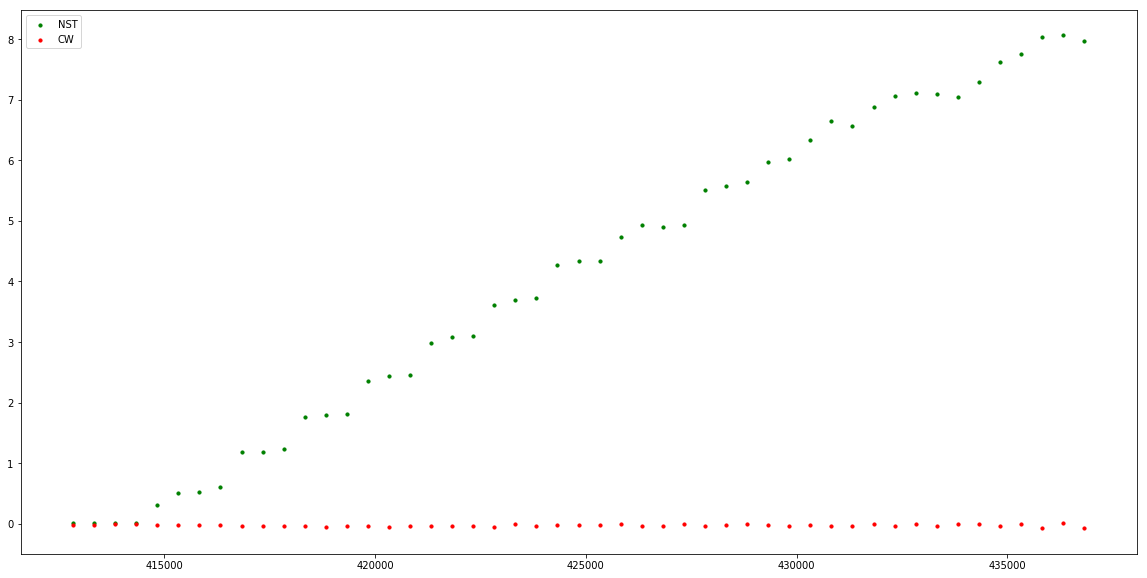

In [0]:
newNSTSolo = Experiment("60mATransformerSolo.txt", (0, 49))
newNSTSolo.show_time_plot()

##Two Boards, 60 mA NST & 33MΩ Load to 140V

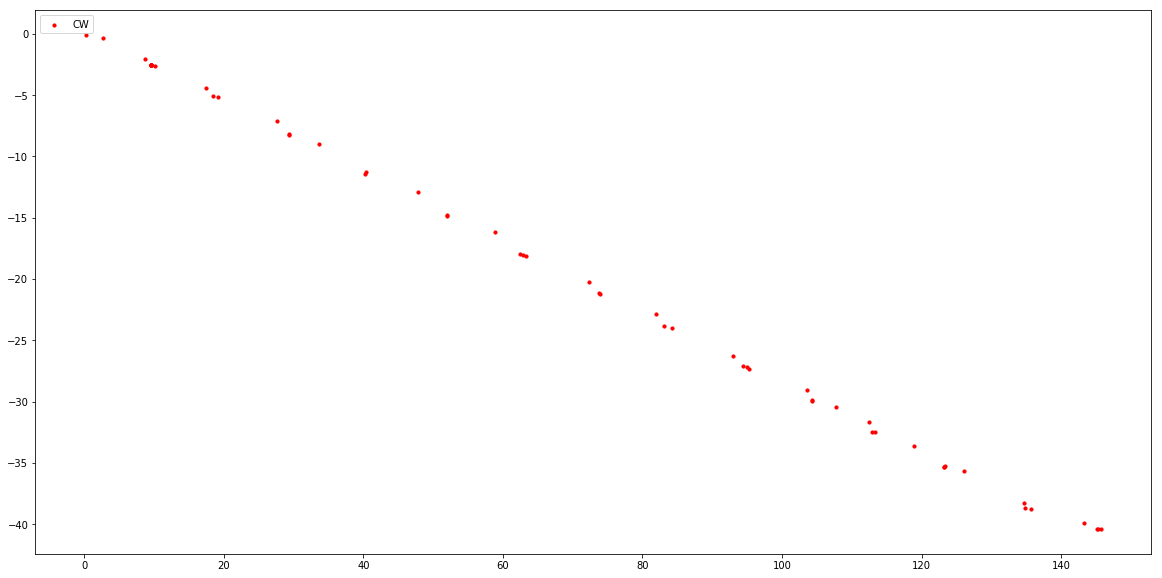

Cockcroft-Walton outputs -39.7 kV from 140.0 V at -1.2 mA (totaling 47.8 W) with 33.00 MΩ resistor


In [0]:
newNSTtwoStage33Mohm = Experiment("CW60mATwoStage33Mohm.txt", (3, 60))
newNSTtwoStage33Mohm.show_voltage_curve()
newNSTtwoStage33Mohm.print_wattage(33, 140)

##Two Boards, 60 mA NST & 3.3MΩ Load to 140V

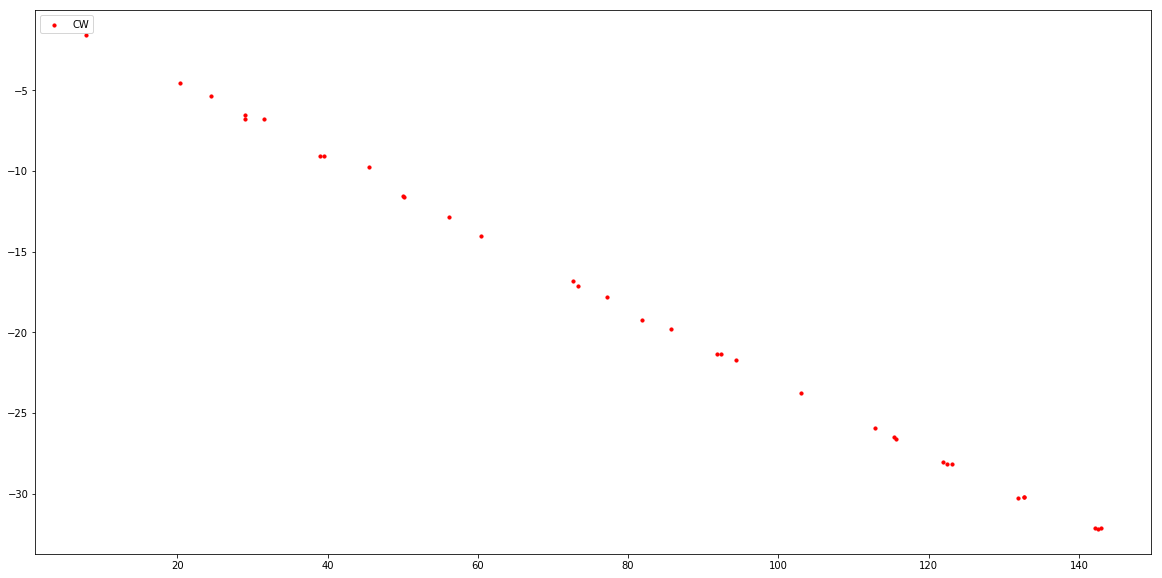

Cockcroft-Walton outputs -32.0 kV from 140.0 V at -9.7 mA (totaling 311.2 W) with 3.30 MΩ resistor


In [0]:
newNSTtwoStage3Mohm = Experiment("CW60mATwoStage3Mohm.txt", (0, 34))
newNSTtwoStage3Mohm.show_voltage_curve()
newNSTtwoStage3Mohm.print_wattage(3.3, 140)

##60 mA NST Voltage curves comparison

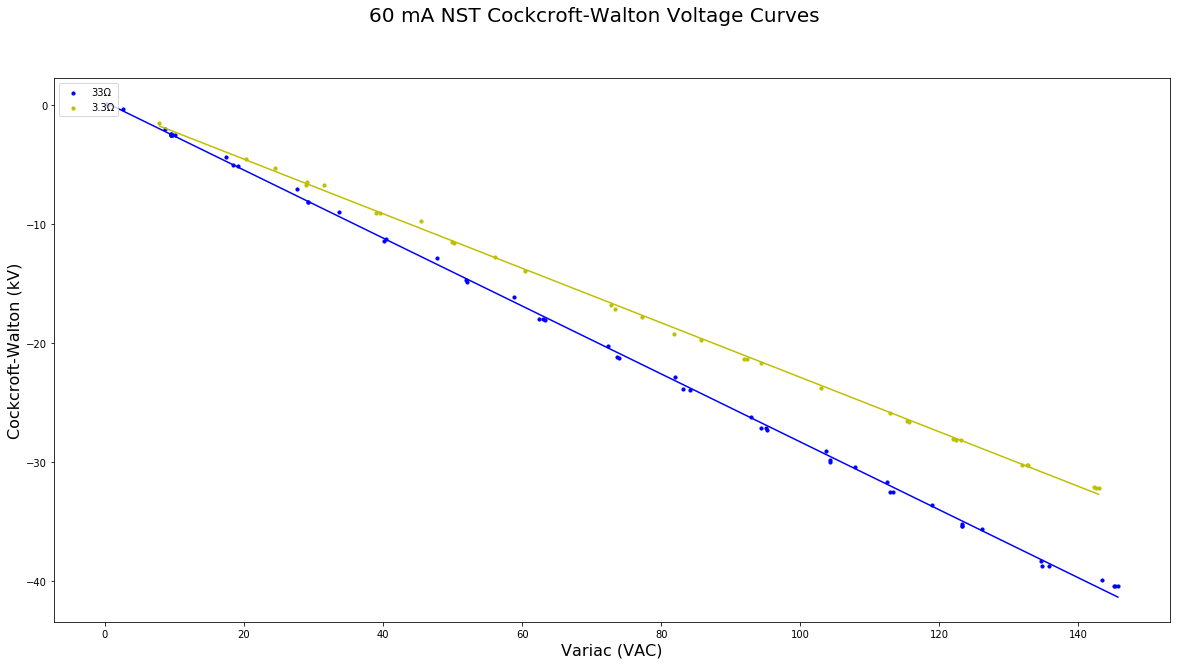

In [0]:
figure = plt.figure()
figure.set_size_inches(20, 10)
axes = figure.add_subplot(111)
figure.suptitle('Cockcroft-Walton Voltage Curves with 60 mA NST', fontsize=20)
plt.xlabel('Variac (VAC)', fontsize=16)
plt.ylabel('Cockcroft-Walton (kV)', fontsize=16)


newNSTtwoStage33Mohm.add_best_fit_line(c='b')
newNSTtwoStage3Mohm.add_best_fit_line(c='y')

axes.scatter(newNSTtwoStage33Mohm.variac_out, newNSTtwoStage33Mohm.cockcroft_walton_out, s=10, c='b', label='33Ω')
axes.scatter(newNSTtwoStage3Mohm.variac_out, newNSTtwoStage3Mohm.cockcroft_walton_out, s=10, c='y', label='3.3Ω')
plt.legend(loc='upper left');
plt.show()

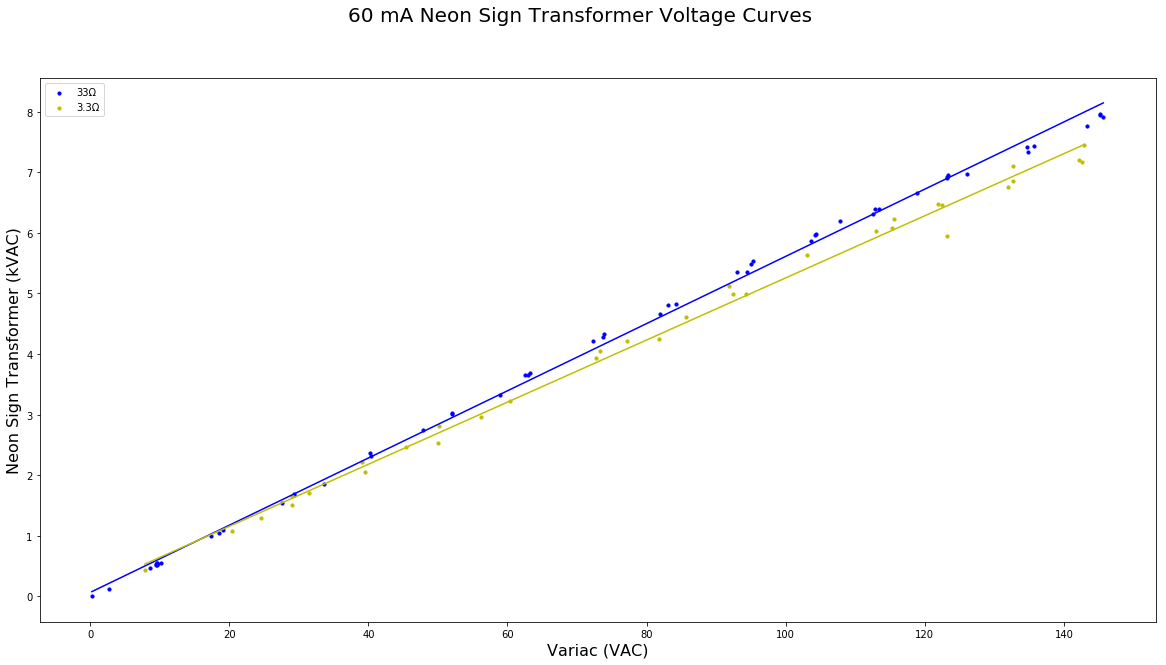

In [0]:
figure = plt.figure()
figure.set_size_inches(20, 10)
axes = figure.add_subplot(111)
figure.suptitle('60 mA Neon Sign Transformer Voltage Curves', fontsize=20)
plt.xlabel('Variac (VAC)', fontsize=16)
plt.ylabel('Neon Sign Transformer (kVAC)', fontsize=16)

newNSTtwoStage33Mohm.add_best_fit_line(y=newNSTtwoStage33Mohm.nst_out, c='b')
newNSTtwoStage3Mohm.add_best_fit_line(y=newNSTtwoStage3Mohm.nst_out, c='y')

axes.scatter(newNSTtwoStage33Mohm.variac_out, newNSTtwoStage33Mohm.nst_out, s=10, c='b', label='33Ω')
axes.scatter(newNSTtwoStage3Mohm.variac_out, newNSTtwoStage3Mohm.nst_out, s=10, c='y', label='3.3Ω')
plt.legend(loc='upper left');
plt.show()

#Conclusion
As required, the Cockcroft-Walton outputs -32 kV at 9.7 mA (311 W) when 140 V is inputted from the Variac. The test was a success.

###Voltage curves
All voltage curves for the Cockcroft-Walton output are almost entirely linear, indicating our capacitors have a capacitance that does not change with voltage (as they were designed). This is good, because this is what we paid several hundred dollars for.

###Neon sign transformer drooping
As seen in the "Neon Sign Voltage Transformer Curves" chart, the 30 mA NST's voltage decreases as more current is drawn from it. This is a significant enough problem that Cockcroft-Walton when powered by the 30 mA NST can only output 8 mA. Since "amount-o-fusion" is proportional to the *square of current*, this would reduce total fusion by about 35%. That would suck.

Thus, we instead purchased a 60 mA NST. While this also droops, it droops a lot less, giving us the 9.7 mA we want.

###Noises and disconnections
When running our tests, the Arduino (which we connected to via Bluetooth) would sometimes spontaneously disconnect for no apparent reason. This did not occur at low input voltages, and seemed to only occur when we changed the voltage. We never determined what caused this issue.

We also sometimes noticed the setup making a "clicking" noise, as though some electricity were being discharged into the air. It was unrelated to the Bluetooth disconnections. We never determined the source of this clicking, as it was deemed unimportant.